# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

## Submitted by Ninad Ghike


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = '/home/udacity/share/traffic_sign_data/train.p'
validation_file = '/home/udacity/share/traffic_sign_data/valid.p'
testing_file = '/home/udacity/share/traffic_sign_data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
X_valid, y_valid = valid['features'], valid['labels']

print("X Train size:", X_train.shape)
print("Y Train size:", y_train.shape)
print("X Test size:", X_test.shape)
print("Y Test size:", y_test.shape)
print("X Validation size:", X_valid.shape)
print("Y Validation size:", y_valid.shape)

X Train size: (34799, 32, 32, 3)
Y Train size: (34799,)
X Test size: (12630, 32, 32, 3)
Y Test size: (12630,)
X Validation size: (4410, 32, 32, 3)
Y Validation size: (4410,)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: Number of validation examples.
n_valid = len(X_valid)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_valid)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

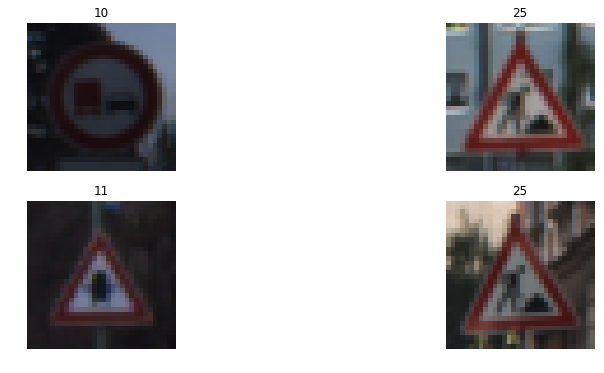

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

# show image of 10 random data points
fig, axs = plt.subplots(2,2, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(4):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

[]

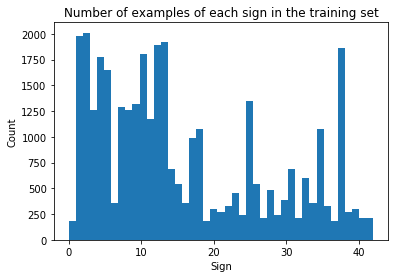

In [4]:
# Plot a histogram of the count of the number of examples of each sign
# in the test set

plt.hist(y_train, bins=n_classes)
plt.title('Number of examples of each sign in the training set')
plt.xlabel('Sign')
plt.ylabel('Count')
plt.plot()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

1. Keeping the data in color format instead of converting them to grayscale:

Color is really important factor according to me when it comes to traffic signs. A red yeild sign is an inverted triangle but that when turned upside down becomes a warning sign.


2. Pre-processing "Normalization"

I read on jessica yung's post that normalization gives higher training and validation accuracy as compared to standardizing the data for a two-layered feedforward network. I decided to go with this network because it seemed to be easy to implement and was capable to running on my local machine instead of AWS. It seemed to be a good start. Also, Normalization helped the model reach the solution much faster.

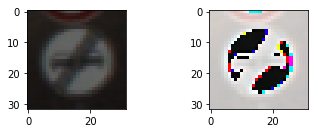

In [5]:

# retain the original data(just in case)
X_train_orig = X_train
X_test_orig = X_test
X_valid_orig = X_valid


# Normalise input (images still in colour)
X_train = (X_train - X_train.mean()) / (np.max(X_train) - np.min(X_train))
X_test = (X_test - X_test.mean()) / (np.max(X_test) - np.min(X_test))
X_valid = (X_valid - X_valid.mean()) / (np.max(X_valid) - np.min(X_valid))

def plot_norm_image(image_index):
    """Plots original image on the left and normalised image on the right."""
    plt.subplot(2,2,1)
    plt.imshow(X_train_orig[image_index])
    plt.subplot(2,2,2)
    plt.imshow(X_train[image_index])
    
    
plot_norm_image(20)


### Model Architecture

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
import time
import pandas as pd
# Network parameters
n_input = 32 * 32 * 3
nb_filters = 32
kernel_size = (3, 3)
input_shape = (32, 32, 3)
n_fc1 = 512
n_fc2 = 128
in_channels = 3
pool_size = 2 # i.e. (2,2)

dropout_conv = 0.9
dropout_fc = 0.9

weights_stddev = 0.1
weights_mean = 0.0
biases_mean = 0.0

padding = 'VALID'
if padding == 'SAME':
    conv_output_length = 6
elif padding == 'VALID':
    conv_output_length = 5
else:
    raiseException("Unknown padding.")

In [7]:
# tf Graph input
x_unflattened = tf.placeholder("float", [None, 32, 32, 3])
x = x_unflattened

y_rawlabels = tf.placeholder("int32", [None])
y = tf.one_hot(y_rawlabels, depth=43, on_value=1., off_value=0., axis=-1)

In [8]:
## Create model

def conv2d(x, W, b, strides=3):
    """Conv2D wrapper, with bias and relu activation"""
    # strides = [batch, in_height, in_width, channels]
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2, padding_setting='SAME'):
    """MaxPool2D wrapper."""
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding=padding_setting)

def conv_net(model_x, model_weights, model_biases, model_pool_size, 
             model_dropout_conv, model_dropout_fc, padding='SAME'):
    """Convolutional neural network model."""
    # Convolution Layer 1
    conv1 = conv2d(model_x, model_weights['conv1'], model_biases['conv1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=model_pool_size, padding_setting=padding)
    conv1 = tf.nn.dropout(conv1, model_dropout_conv)

    # Fully connected layer 1
    # Reshape conv1 output to fit fully connected layer input
    conv1_shape = conv1.get_shape().as_list()
    fc1 = tf.reshape(conv1, [-1, conv1_shape[1]*conv1_shape[2]*conv1_shape[3]])
    fc1 = tf.add(tf.matmul(fc1, model_weights['fc1']), model_biases['fc1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, model_dropout_fc)
    # Fully connected layer 2
    fc2 = tf.add(tf.matmul(fc1, model_weights['fc2']), model_biases['fc2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, model_dropout_fc)
    # Output layer
    output = tf.add(tf.matmul(fc2, model_weights['out']), model_biases['out'])
    # Note: Softmax is outside the model
    return output


## Store layers weight & bias

# NEW: initialise neurons with slightly positive initial bias
# to avoid dead neurons.
def weight_variable(shape, weight_mean, weight_stddev):
    initial = tf.truncated_normal(shape, stddev=weight_stddev, mean=weight_mean)
    # alt: tf.random_normal(shape)
    return tf.Variable(initial)


def bias_variable(shape, bias_mean):
    initial = tf.constant(bias_mean, shape=shape)
    return tf.Variable(initial)


weights = {
    'conv1': weight_variable([kernel_size[0], kernel_size[1], in_channels, nb_filters], weights_mean, weights_stddev),
    'fc1': weight_variable([nb_filters * conv_output_length**2, n_fc1], weights_mean, weights_stddev),
    'fc2': weight_variable([n_fc1, n_fc2], weights_mean, weights_stddev),
    'out': weight_variable([n_fc2, n_classes], weights_mean, weights_stddev)
}

biases = {
    'conv1': bias_variable([nb_filters], biases_mean),
    'fc1': bias_variable([n_fc1], biases_mean),
    'fc2': bias_variable([n_fc2], biases_mean),
    'out': bias_variable([n_classes], biases_mean)
}

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [9]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [10]:


x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)



In [11]:
rate = 0.001
EPOCHS = 10
BATCH_SIZE = 128
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [12]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [13]:
from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")


Training...

EPOCH 1 ...
Validation Accuracy = 0.720

EPOCH 2 ...
Validation Accuracy = 0.829

EPOCH 3 ...
Validation Accuracy = 0.841

EPOCH 4 ...
Validation Accuracy = 0.879

EPOCH 5 ...
Validation Accuracy = 0.877

EPOCH 6 ...
Validation Accuracy = 0.882

EPOCH 7 ...
Validation Accuracy = 0.892

EPOCH 8 ...
Validation Accuracy = 0.877

EPOCH 9 ...
Validation Accuracy = 0.897

EPOCH 10 ...
Validation Accuracy = 0.890

Model saved


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [14]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [15]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [16]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [17]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In [18]:
# Close the current session.
sess.close()